In [35]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import network_module as nm
import argparse

def print_csv(filename, data):
    with open(filename, 'wb') as out:
        for t in data:
            out.write('{}\t{}\n'.format(*t))


# layer_params = sys.argv[1:]

# netname = 'mnist-fc-784-'
# for width in layer_params:
#     netname += '{}-'.format(width)
# netname += '10'
reg = 0
L1 = False
L2 = False
L05 = False
netname = 'conv5-3x3-maxpool-100'
data_source = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

def loadcifar():
    import cPickle
    import os.path

    if not os.path.exists('./cifar-10-batches-py/data_batch_1'):
        print 'Downloading train data from', data_source
        import urllib
        import tarfile
        if not os.path.exists('./cifar-10-batches-py/'):
            os.makedirs('./cifar-10-batches-py/')
            
        dest = "./cifar-10-batches-py/data.tar.gz"
        urllib.urlretrieve(data_source, dest)
        print 'unzipping train data'
        tar = tarfile.open(dest, "r:gz")
        tar.extractall()
        tar.close()
    
    
    # Load the dataset
    f = open('./cifar-10-batches-py/data_batch_1', 'rb')
    train = cPickle.load(f)
    f.close()
    train_data = train['data'].reshape(-1,3,32,32).astype(float)
    train_data /= 255.
    label = np.array(train['labels'])
    train_onehot = np.zeros((label.size, label.max() + 1))
    train_onehot[np.arange(label.size), label] = 1

    f = open('./cifar-10-batches-py/test_batch', 'rb')
    test = cPickle.load(f)
    f.close()
    test_data = test['data'][:1000].reshape(-1,3,32,32).astype(float)
    test_data /= 255.
    label = np.array(test['labels'])
    test_onehot = np.zeros((label.size, label.max() + 1))
    test_onehot[np.arange(label.size), label] = 1


    return [(train_data, train_onehot), (test_data, test_onehot)]


print 'Loading CIFAR images...'
train, test = loadcifar()
train = (train[0][:1000], train[1][:1000])
test = (test[0][:100], test[1][:100])

print 'Constructing network...'
#########################
# NETWORK DEFINITION
nn = nm.network(in_shape=train[0][0].shape, criterion='softmax')
nn.add_conv(10, (5,5))
nn.add_maxpool()
nn.add_activation('relu')
nn.add_conv(10, (5,5))
nn.add_activation('tanh')
nn.add_shaper(np.prod(nn[-1].shape))
nn.add_full(10)
#########################
print nn

result = []


def print_test():
    print ' --- Epoch: ', nn.last_epoch, ' error: ',\
          nn.output.get_crit(train[0][0:16], train[1][0:16]).mean()

print 'Working with network:', netname
def train_net():
  print 'Training network:', netname
  nn.SGD(train_policy=nn.fix_epoch,
         training_set=train,
         L2=True, reg=0.0001,
         batch=128, rate=0.003, epoch_call_back=print_test, epoch=6)


  print 'Saving results to {}.res'.format(netname)
  print_csv('./results/{}.res'.format(netname), result)

  print 'Saving network snapshot to {}.net'.format(netname)
  nn.save_state('./nets/' + netname + '.net')



def loadnetwork(network_source):
    global nn
    nn = nm.load(network_source)

    
def imshow(im, cmap='Greys_r', interpol='None'):

    if len(im.shape) == 2:
        plt.imshow(im.squeeze(), cmap=cmap, interpolation=interpol)
        plt.axis('off')
    
    if len(im.shape) == 3:
        for i, x in enumerate(im, 1):
            plt.subplot(1, len(im), i)
            plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.axis('off')
    if len(im.shape) == 4:
        for irow, xrow in enumerate(im, 0):
            for icol, x in enumerate(xrow, 1):
                #print '\r  ', len(im), len(xrow), irow * len(xrow) + icol
                plt.subplot(len(im), len(xrow), irow * len(xrow) + icol)
                plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.axis('off')
                
    if len(im.shape) == 5:
        for irow, xrow in enumerate(im, 0):
            for icol, x in enumerate(xrow, 1):
                #print '\r  ', len(im), len(xrow), irow * len(xrow) + icol
                plt.subplot(len(im), len(xrow), irow * len(xrow) + icol)
                plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.axis('off')
    
    plt.show()
    return im.shape


def visualise_layer(lay_ind=4, top=9, iterations=1000):
    test = nn.grad_ascent(lay_ind, train[0], top, iterations)\
             .reshape((top,) + nn[lay_ind].shape + (3, 32, 32))
    test = np.concatenate((test, test.mean(axis=0)[np.newaxis, :]), axis=0)
    return test


def max_act(lay_ind, top=9):
    return test[0][nn.max_act(lay_ind, test[0], top)].squeeze()
    
def gradient_check(eps=0.001):
    nn[1].kernels[0,0,0,0] += eps
    dp = nn.output.get_crit(test[0][0], test[1][0])[0]
    nn[1].kernels[0,0,0,0] -= 2 * eps
    dm = nn.output.get_crit(test[0][0], test[1][0])[0]    
    nn[1].kernels[0,0,0,0] += eps
    return (dp-dm)/2/eps


Loading CIFAR images...
Constructing network...
Network ID: 140664331175056
Network layout:
------------------------------
	INPUT  (3, 32, 32)
	   |
	   |
	  |1|
  convolution  (10, 28, 28)   ->   kernels: (3, 10, 5, 5)
	   |
	   |
	  |2|
  max pool  (10, 14, 14)   ->   pool shape: (2, 2)
	   |
	   |
	  |3|
  activation (10, 14, 14)   ->   type: relu
	   |
	   |
	  |4|
  convolution  (10, 10, 10)   ->   kernels: (10, 10, 5, 5)
	   |
	   |
	  |5|
  activation (10, 10, 10)   ->   type: tanh
	   |
	   |
	  |6|
  shaper  (1000,)
	   |
	   |
	  |7|
  fully connected  (10,)   ->   weights + bias: (10, 1000) + (10,)
	   |
	   |
	  |8|
  	OUTPUT  (10,)   ->   CRITERION  (softmax)
------------------------------
Working with network: conv5-3x3-maxpool-100


In [36]:
def print_outputs():
    nn.get_output(train[0][0:3])
    imshow(nn[0].output)
    imshow(nn[1].output)
    imshow(nn[4].output)

In [ ]:
train_net()

Training network: conv5-3x3-maxpool-100
   batch: 1 of 7

   3 3 1
   3 3 2
   3 3 3
   3 3 4
   3 3 5
   3 3 6
   3 3 7
   3 3 8
   3 3 9


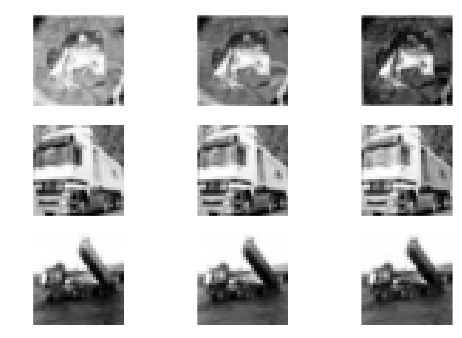

   3 5 1
   3 5 2
   3 5 3
   3 5 4
   3 5 5
   3 5 6
   3 5 7
   3 5 8
   3 5 9
   3 5 10
   3 5 11
   3 5 12
   3 5 13
   3 5 14
   3 5 15


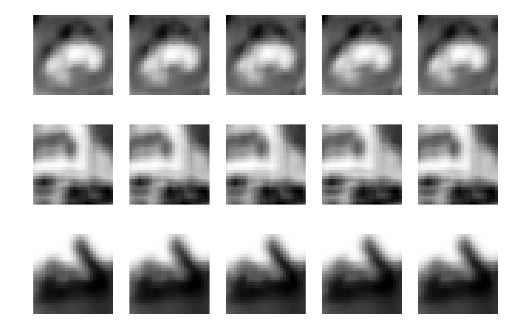

   3 3 1
   3 3 2
   3 3 3
   3 3 4
   3 3 5
   3 3 6
   3 3 7
   3 3 8
   3 3 9


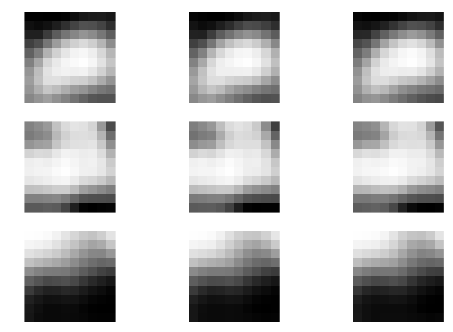

In [26]:
print_outputs()

In [31]:
nn.test_eval(train)

99

In [30]:
for k in nn[1].kernels[0]: print k

[[ 0.3   0.34 ...,  0.17  0.21]
 [ 0.62  0.37 ...,  0.82  0.73]
 ..., 
 [ 0.72  0.44 ...,  0.4   0.39]
 [ 0.61  0.64 ...,  0.68  0.14]]
[[ 0.37  0.62 ...,  0.37  0.22]
 [ 0.57  0.56 ...,  0.6   0.19]
 ..., 
 [ 0.94  0.8  ...,  0.81  0.55]
 [ 0.87  0.06 ...,  0.55  0.25]]
[[ 0.93  0.57 ...,  0.22  0.3 ]
 [ 0.75  0.88 ...,  0.34  0.8 ]
 ..., 
 [ 0.04  0.65 ...,  0.83  0.85]
 [ 0.69  0.24 ...,  0.71  0.3 ]]
[[ 0.4   0.19 ...,  0.79  0.49]
 [ 0.17  0.51 ...,  0.18  0.39]
 ..., 
 [ 0.97  0.48 ...,  0.7   0.27]
 [ 0.78  0.93 ...,  0.46  0.13]]
[[ 0.98  0.24 ...,  1.    0.58]
 [ 0.2   0.9  ...,  0.03  0.23]
 ..., 
 [ 0.74  0.26 ...,  0.29  0.62]
 [ 0.98  0.24 ...,  0.51  0.31]]
